### Imports

In [2]:
from experiments.class_conditioned_alignment import class_conditioned_alignment, class_conditioned_alignment_shared
from experiments.compared_shared_encoder import compare_shared_encoder_alignment
from data.loader import get_dataloader
from models.models import SplitEncoder
from models.models import SplitDecoder
from models.models import LinearProbe, DomainProbe
from utils.aligner import finetune_entropy, finetune_entropy_detach_stabilized, finetune_entropy_detach_usps_contrastive, finetune_domain_adversary
import torch
from utils.plotting import plot_latent_tsne_before_after, plot_latent_tsne_grid
from utils.seed import set_seed

In [4]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_M = torch.load("artifacts/mnist/mnist_pretrained_usage_swap_asym.pt", map_location=device)
ckpt_U = torch.load("artifacts/usps/usps_pretrained_usage_swap_asym.pt", map_location=device)

In [6]:
input_dim = 784
output_dim = 784
latent_dim = 64
signal_dim = 32
num_classes = 10

encoder_M = SplitEncoder(input_dim=input_dim, latent_dim=latent_dim, signal_dim=signal_dim).to(device)
decoder_M = SplitDecoder(latent_dim=latent_dim, output_dim=output_dim).to(device)
probe_M = LinearProbe()

encoder_U = SplitEncoder(input_dim=input_dim, latent_dim=latent_dim, signal_dim=signal_dim).to(device)
decoder_U = SplitDecoder(latent_dim=latent_dim, output_dim=output_dim).to(device)
probe_U = LinearProbe()

In [7]:
encoder_M.load_state_dict(ckpt_M["encoder"])
decoder_M.load_state_dict(ckpt_M["decoder"])
probe_M.load_state_dict(ckpt_M["probe"])

encoder_U.load_state_dict(ckpt_U["encoder"])
decoder_U.load_state_dict(ckpt_U["decoder"])
probe_U.load_state_dict(ckpt_U["probe"])

<All keys matched successfully>

In [8]:
loader_M = get_dataloader("mnist", batch_size=256, train=False)
loader_U = get_dataloader("usps", batch_size=256, train=False)

domain_probe_M = DomainProbe(in_dim=32).to(device)
domain_probe_U = DomainProbe(in_dim=32).to(device)

### Results Prior to Finetuning on USPS

In [9]:
print("== Before finetune ==")
print("\n---- MNIST to USPS ----\n")
_ = compare_shared_encoder_alignment(encoder_M, decoder_M, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_M, decoder_M, loader_M, loader_U, device
)
print("\n---- USPS to MNIST ----\n")
_ = compare_shared_encoder_alignment(encoder_U, decoder_U, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_U, decoder_U, loader_U, loader_M, device
)

== Before finetune ==

---- MNIST to USPS ----

[Domain probe on signal] acc=65.40% | AUC=0.743
[Domain probe on nuisance] acc=63.35% | AUC=0.703
[MNIST] Var(z_s)=9.6935e-02  Var(z_n)=2.6360e-03  ‖z_s‖=1.7153  ‖z_n‖=1.7984
[USPS] Var(z_s)=4.5405e-01  Var(z_n)=2.9220e-02  ‖z_s‖=2.5632  ‖z_n‖=1.9410
Δrecon after z_n swap (mean |x−x'|) = 0.009667

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=104.5470 | MMD=0.0622
Nuisance latent           | CORAL=0.5912 | MMD=0.0177
Full latent               | CORAL=118.1416 | MMD=0.0638
Reconstruction            | CORAL=6.7486 | MMD=0.0619
Stationarized recon       | CORAL=8.1889 | MMD=0.0959


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 296.18it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=64.2534  MMD=0.5302
Class  1: CORAL=1.0718  MMD=0.7130
Class  2: CORAL=5.0532  MMD=0.2616
Class  3: CORAL=2.1416  MMD=0.1121
Class  4: CORAL=1.2950  MMD=0.3983
Class  5: CORAL=10.1082  MMD=0.2501
Class  6: CORAL=2.7917  MMD=0.7233
Class  7: CORAL=1.9773  MMD=0.6664
Class  8: CORAL=0.2154  MMD=0.0136
Class  9: CORAL=1.9150  MMD=0.7679
Avg: CORAL=9.0823  MMD=0.4436

---- USPS to MNIST ----



[Domain probe on signal] acc=83.45% | AUC=0.881
[Domain probe on nuisance] acc=72.25% | AUC=0.809
[MNIST] Var(z_s)=1.5588e-01  Var(z_n)=1.4027e-03  ‖z_s‖=2.7506  ‖z_n‖=1.7973
[USPS] Var(z_s)=4.7786e-01  Var(z_n)=1.5678e-03  ‖z_s‖=3.7494  ‖z_n‖=1.9402
Δrecon after z_n swap (mean |x−x'|) = 0.009527

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=60.3255 | MMD=0.1466
Nuisance latent           | CORAL=0.0261 | MMD=0.0236
Full latent               | CORAL=60.4786 | MMD=0.1449
Reconstruction            | CORAL=13.1704 | MMD=0.1798
Stationarized recon       | CORAL=14.6490 | MMD=0.1841


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 231.97it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=5.5724  MMD=0.5430
Class  1: CORAL=1.6035  MMD=0.4362
Class  2: CORAL=1.7592  MMD=0.1007
Class  3: CORAL=6.3075  MMD=0.6643
Class  4: CORAL=0.2450  MMD=0.0903
Class  5: CORAL=3.4456  MMD=0.2838
Class  6: CORAL=13.5263  MMD=1.1193
Class  7: CORAL=11.6882  MMD=1.0019
Class  8: CORAL=1.5705  MMD=0.4883
Class  9: CORAL=6.5217  MMD=1.1956
Avg: CORAL=5.2240  MMD=0.5923


In [10]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_M,
    device=device,
    save_path="artifacts/plots/mnist_mnist_pretrained_latent_grid.png",
    n_samples=1000,
    title_prefix="MNIST Pretrained Model"
)

[t-SNE] Running joint projection...
✅ t-SNE plot saved to artifacts/plots/mnist_mnist_pretrained_latent_grid.png


In [11]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_M,
    device=device,
    save_path="artifacts/plots/mnist_usps_pretrained_latent_grid.png",
    n_samples=1000,
    title_prefix="USPS Pretrained Model"
)

[t-SNE] Running joint projection...
✅ t-SNE plot saved to artifacts/plots/mnist_usps_pretrained_latent_grid.png


### Step 1: Finetuning for reduce MMD and CORAL

In [12]:
print("\n -- Finetuning Step 1 MNIST encoder-decoder -- \n")
finetune_entropy_detach_stabilized(
    encoder_M, decoder_M, probe_M,
    loader_mnist=loader_M,
    loader_usps=loader_U,
    device=device,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3,
    epochs=3, lr=1e-4
)
print("\n -- Finetuning Step 1 USPS encoder-decoder -- \n")
finetune_entropy_detach_stabilized(
    encoder_U, decoder_M, probe_U,
    loader_mnist=loader_U,
    loader_usps=loader_M,
    device=device,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3,
    epochs=3, lr=1e-4
)


 -- Finetuning Step 1 MNIST encoder-decoder -- 

[Finetune Detach+Stabilized 1/3] Loss=0.7726 Cls=0.1980 Rec=0.7058 Ent=0.6809 Zvar=0.0215 Swap=1.6549
[Finetune Detach+Stabilized 2/3] Loss=0.7602 Cls=0.1914 Rec=0.7014 Ent=0.6698 Zvar=0.0216 Swap=1.6509
[Finetune Detach+Stabilized 3/3] Loss=0.7136 Cls=0.1479 Rec=0.7040 Ent=0.6556 Zvar=0.0255 Swap=1.6440

 -- Finetuning Step 1 USPS encoder-decoder -- 

[Finetune Detach+Stabilized 1/3] Loss=1.2898 Cls=0.5015 Rec=0.8974 Ent=1.0619 Zvar=0.0004 Swap=1.9725
[Finetune Detach+Stabilized 2/3] Loss=1.2517 Cls=0.4778 Rec=0.8772 Ent=1.0482 Zvar=0.0005 Swap=1.9613
[Finetune Detach+Stabilized 3/3] Loss=1.2165 Cls=0.4672 Rec=0.8727 Ent=0.9741 Zvar=0.0006 Swap=1.9487


In [13]:
print("== After finetune step 1 ==")
print("\n---- MNIST to USPS ----\n")
_ = compare_shared_encoder_alignment(encoder_M, decoder_M, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_M, decoder_M, loader_M, loader_U, device
)
print("\n---- USPS to MNIST ----\n")
_ = compare_shared_encoder_alignment(encoder_U, decoder_U, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_U, decoder_U, loader_U, loader_M, device
)

== After finetune step 1 ==

---- MNIST to USPS ----

[Domain probe on signal] acc=72.70% | AUC=0.837
[Domain probe on nuisance] acc=71.70% | AUC=0.787
[MNIST] Var(z_s)=1.1834e-01  Var(z_n)=3.1371e-03  ‖z_s‖=1.9345  ‖z_n‖=1.8681
[USPS] Var(z_s)=3.4796e-01  Var(z_n)=3.9864e-02  ‖z_s‖=2.4714  ‖z_n‖=2.1703
Δrecon after z_n swap (mean |x−x'|) = 0.009087

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=42.6241 | MMD=0.0751
Nuisance latent           | CORAL=1.0995 | MMD=0.0286
Full latent               | CORAL=53.2866 | MMD=0.0753
Reconstruction            | CORAL=1.8759 | MMD=0.0782
Stationarized recon       | CORAL=3.9723 | MMD=0.1093


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 280.19it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=29.0384  MMD=0.5740
Class  1: CORAL=0.9650  MMD=0.6700
Class  2: CORAL=2.9797  MMD=0.2327
Class  3: CORAL=1.3839  MMD=0.0890
Class  4: CORAL=1.5518  MMD=0.4134
Class  5: CORAL=4.9386  MMD=0.2273
Class  6: CORAL=1.7885  MMD=0.5697
Class  7: CORAL=2.8351  MMD=0.8257
Class  8: CORAL=0.1838  MMD=0.0208
Class  9: CORAL=3.0581  MMD=0.9442
Avg: CORAL=4.8723  MMD=0.4567

---- USPS to MNIST ----



[Domain probe on signal] acc=88.10% | AUC=0.916
[Domain probe on nuisance] acc=86.55% | AUC=0.926
[MNIST] Var(z_s)=1.9463e-01  Var(z_n)=1.5756e-03  ‖z_s‖=3.1379  ‖z_n‖=1.9779
[USPS] Var(z_s)=5.2235e-01  Var(z_n)=1.8634e-03  ‖z_s‖=3.9428  ‖z_n‖=2.1156
Δrecon after z_n swap (mean |x−x'|) = 0.008326

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=62.5882 | MMD=0.1124
Nuisance latent           | CORAL=0.0303 | MMD=0.0276
Full latent               | CORAL=62.7885 | MMD=0.1112
Reconstruction            | CORAL=11.5004 | MMD=0.1626
Stationarized recon       | CORAL=13.0686 | MMD=0.1671


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 232.22it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=6.2510  MMD=0.5841
Class  1: CORAL=1.7744  MMD=0.3310
Class  2: CORAL=1.6647  MMD=0.1154
Class  3: CORAL=7.7055  MMD=0.6335
Class  4: CORAL=0.3403  MMD=0.1292
Class  5: CORAL=3.8650  MMD=0.3237
Class  6: CORAL=12.4440  MMD=1.0971
Class  7: CORAL=13.0117  MMD=0.9348
Class  8: CORAL=2.1939  MMD=0.5446
Class  9: CORAL=7.2703  MMD=1.1227
Avg: CORAL=5.6521  MMD=0.5816


In [ ]:
print("\n -- Finetuning Step 2 MNIST encoder-decoder -- \n")
finetune_entropy_detach_usps_contrastive(
    encoder_M, decoder_M, probe_M,
    loader_M, loader_U,
    device,
    domain_probe=domain_probe_M,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3, lambda_dom=0.2,
    epochs=3, lr=1e-4,
    save_path="artifacts/mnist/mnist_finetuned.pt"
)
print("\n -- Finetuning Step 2 USPS encoder-decoder -- \n")
finetune_entropy_detach_usps_contrastive(
    encoder_U, decoder_U, probe_U,
    loader_U, loader_M,
    device,
    domain_probe=domain_probe_M,
    lambda_cls=1.0, lambda_rec=0.5, lambda_ent=0.3, lambda_dom=0.2,
    epochs=3, lr=1e-4,
    save_path="artifacts/usps/usps_finetuned.pt"
)


 -- Finetuning Step 2 MNIST encoder-decoder -- 

[Finetune Detach+Contrastive 1/3] Loss=0.8454 Cls=0.1730 Rec=0.6891 Ent=0.6331 Dom=0.6895
[Finetune Detach+Contrastive 2/3] Loss=0.8495 Cls=0.1861 Rec=0.6877 Ent=0.6119 Dom=0.6802
[Finetune Detach+Contrastive 3/3] Loss=0.8017 Cls=0.1426 Rec=0.6928 Ent=0.5947 Dom=0.6714
✅ USPS finetune (detach + contrastive) saved to artifacts/mnist/mnist_finetuned_usps_detach_contrastive.pt

 -- Finetuning Step 2 USPS encoder-decoder -- 

[Finetune Detach+Contrastive 1/3] Loss=1.3643 Cls=0.4627 Rec=0.8944 Ent=0.9726 Dom=0.8128
[Finetune Detach+Contrastive 2/3] Loss=1.3470 Cls=0.4489 Rec=0.8668 Ent=1.0097 Dom=0.8089
[Finetune Detach+Contrastive 3/3] Loss=1.3150 Cls=0.4401 Rec=0.8555 Ent=0.9541 Dom=0.8047
✅ USPS finetune (detach + contrastive) saved to artifacts/mnist/mnist_finetuned_usps_detach_contrastive.pt


In [15]:
print("== After finetune step 2 ==")
print("\n---- MNIST to USPS ----\n")
_ = compare_shared_encoder_alignment(encoder_M, decoder_M, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_M, decoder_M, loader_M, loader_U, device
)

print("\n---- USPS to MNIST ----\n")
_ = compare_shared_encoder_alignment(encoder_U, decoder_U, loader_M, loader_U, device, visualize=False)
_ = class_conditioned_alignment_shared(
    encoder_U, decoder_U, loader_U, loader_M, device
)

== After finetune step 2 ==

---- MNIST to USPS ----

[Domain probe on signal] acc=70.60% | AUC=0.829
[Domain probe on nuisance] acc=75.10% | AUC=0.853
[MNIST] Var(z_s)=1.2456e-01  Var(z_n)=4.0786e-03  ‖z_s‖=1.9843  ‖z_n‖=1.8726
[USPS] Var(z_s)=3.6995e-01  Var(z_n)=7.0165e-02  ‖z_s‖=2.5789  ‖z_n‖=2.3569
Δrecon after z_n swap (mean |x−x'|) = 0.010157

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=47.2741 | MMD=0.0730
Nuisance latent           | CORAL=3.3813 | MMD=0.0490
Full latent               | CORAL=68.1869 | MMD=0.0728
Reconstruction            | CORAL=2.2258 | MMD=0.0853
Stationarized recon       | CORAL=4.1800 | MMD=0.1259


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 333.99it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=27.7802  MMD=0.6240
Class  1: CORAL=1.1374  MMD=0.7276
Class  2: CORAL=2.9225  MMD=0.2220
Class  3: CORAL=1.7434  MMD=0.0938
Class  4: CORAL=1.8287  MMD=0.4216
Class  5: CORAL=4.8308  MMD=0.2283
Class  6: CORAL=1.9979  MMD=0.6209
Class  7: CORAL=3.1712  MMD=0.8515
Class  8: CORAL=0.2411  MMD=0.0349
Class  9: CORAL=3.7963  MMD=0.9748
Avg: CORAL=4.9450  MMD=0.4800

---- USPS to MNIST ----



[Domain probe on signal] acc=89.65% | AUC=0.935
[Domain probe on nuisance] acc=89.35% | AUC=0.963
[MNIST] Var(z_s)=2.1058e-01  Var(z_n)=1.3947e-03  ‖z_s‖=3.2801  ‖z_n‖=2.5773
[USPS] Var(z_s)=5.5964e-01  Var(z_n)=3.1505e-03  ‖z_s‖=4.1095  ‖z_n‖=2.4885
Δrecon after z_n swap (mean |x−x'|) = 0.004182

=== Shared Encoder Cross-Domain Alignment ===
Signal latent             | CORAL=70.0982 | MMD=0.1012
Nuisance latent           | CORAL=0.0248 | MMD=0.0203
Full latent               | CORAL=70.7854 | MMD=0.0999
Reconstruction            | CORAL=12.1914 | MMD=0.1827
Stationarized recon       | CORAL=8.4624 | MMD=0.1849


Class-conditioned (shared encoder): 100%|██████████| 10/10 [00:00<00:00, 296.11it/s]


=== Class-Conditioned Alignment (Shared Encoder) ===
Class  0: CORAL=6.3280  MMD=0.6002
Class  1: CORAL=1.5833  MMD=0.3062
Class  2: CORAL=0.9221  MMD=0.1232
Class  3: CORAL=6.5929  MMD=0.6573
Class  4: CORAL=0.2712  MMD=0.1234
Class  5: CORAL=3.0222  MMD=0.3274
Class  6: CORAL=10.5708  MMD=1.1145
Class  7: CORAL=8.8564  MMD=0.9785
Class  8: CORAL=1.9158  MMD=0.4904
Class  9: CORAL=5.0071  MMD=1.1137
Avg: CORAL=4.5070  MMD=0.5835


[t-SNE] Running joint projection...


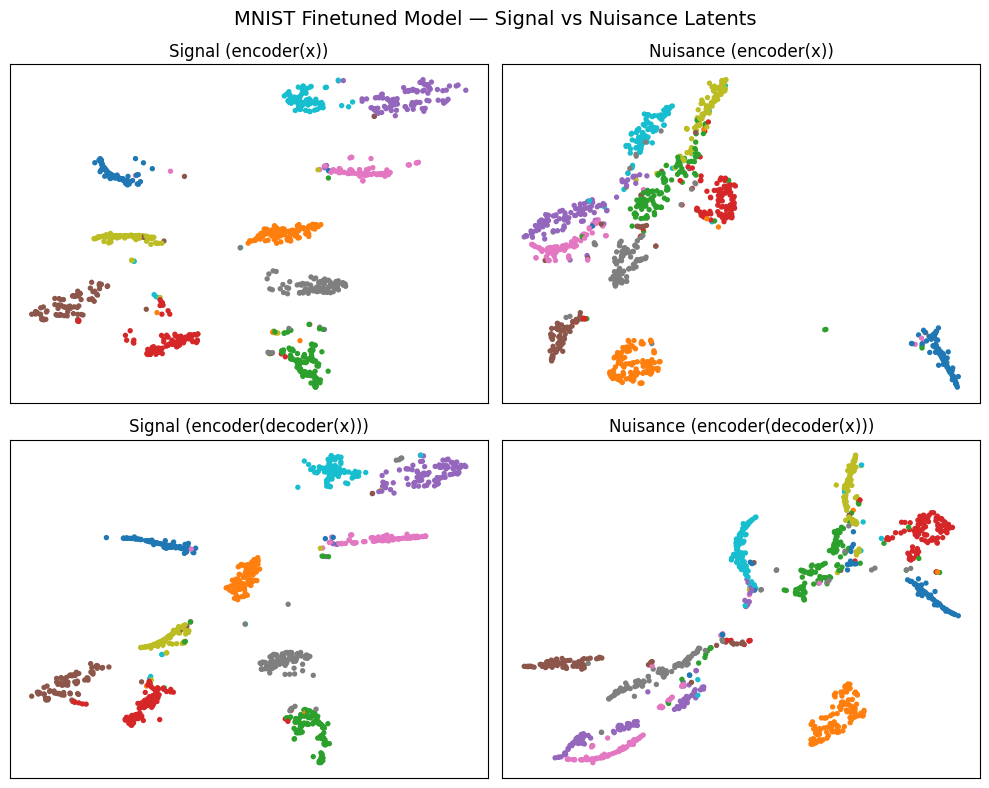

In [16]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_M,
    device=device,
    save_path=None,
    n_samples=1000,
    title_prefix="MNIST Finetuned Model"
)

In [22]:
plot_latent_tsne_grid(
    encoder=encoder_M,
    decoder=decoder_M,
    dataloader=loader_U,
    device=device,
    save_path="artifacts/plots/mnist_usps_finetuned_latent_grid.png",
    n_samples=1000,
    title_prefix="MNIST Finetuned Model"
)

[t-SNE] Running joint projection...
✅ t-SNE plot saved to artifacts/plots/mnist_usps_finetuned_latent_grid.png
